In [1]:
#@title Install arviz
# !pip3 install arviz

In [1]:
import arviz as az
import pystan
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [9]:
stancode = """
functions {
            real[] SIR(real t,  // time
            real[] u,           // system state {infected,cases,susceptible}
            real[] theta,       // parameters 
            real[] x_r,
            int[] x_i) {

            real du_dt[2];

            real sigmac = theta[1];
            real sigmar = theta[2];
            real sigmad =  theta[3];
            real q = theta[4]; 
            real beta = theta[5];
            real mbase = theta[6]; 
            real mlocation = theta[7]; 
            real mrate = theta[8]; 
            real cmax = theta[9];
            real c50 = theta[10];
            
            real I = u[1];  # unknown infected
            real C = u[2];  # cases
            
            beta *= mbase + mbase + (1-mbase)/(1 + exp(mrate*(t - mlocation)));
            sigmac *= 1 + cmax*t/(c50+t);
            
            
            du_dt[1] = beta*(I+q*C) - sigmac*I - (sigmar+sigmad)*I; //I
            du_dt[2] = sigmac*I - (sigmar+sigmad)*C; //C
            
            return du_dt;
          }
        }

        data {
          int<lower = 1> n_obs;       // number of days observed
          int<lower = 1> n_theta;     // number of model parameters
          int<lower = 1> n_difeq;     // number of differential equations for yhat
          int<lower = 1> n_ostates;     // number of observed states
          int<lower = 1> n_pop;       // population
          real<lower = 1> n_scale;       // scale to match observed scale
          int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
          real t0;                // initial time point 
          real tm; //start day of mitigation
          real ts[n_obs];         // time points that were observed
          int<lower = 1> n_obs_predict;       // number of days to predict
          real ts_predict[n_obs_predict];         // 
        }

        transformed data {
            real x_r[0];
            int x_i[0];           
        }

        parameters {
            real<lower = 0> theta[n_theta]; // model parameters 
        }

        transformed parameters{
            real u[n_obs, n_difeq]; // solution from the ODE solver
            real u_init[n_difeq];     // initial conditions for fractions
            
            real sigmac = theta[1];
            real sigmar = theta[2];
            real sigmad =  theta[3];
            real q = theta[4]; 
            real beta = theta[5];
            real mbase = theta[6]; 
            real mlocation = theta[7]; 
            real mrate = theta[8]; 
            real cmax = theta[9];
            real c50 = theta[10];
            real theta_init = theta[11];
            
            beta *= mbase + (1-mbase)/(1 + exp(mrate*(t0 - mlocation)));
            sigmac *= 1 + cmax*t0/(c50+t0);
        
            u_init[2] = y[1,1]/n_scale; //C
            u_init[1] = (beta - (sigmar+sigmad))/sigmac * u_init[2] + theta_init/n_scale; // I
                     
            u = integrate_ode_rk45(SIR, u_init, t0, ts, theta, x_r, x_i);
  
        }

        model {
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]

            //priors
            
            //for (i in 1:n_theta){theta[1] ~ lognormal(log(0.1),10);};
            //theta[5] ~ lognormal(log(0.25),10);
            
            
            theta[1] ~ lognormal(log(0.1),1); //sigmac
            theta[2] ~ lognormal(log(0.1),1); //sigmar
            theta[3] ~ lognormal(log(0.1),1); //sigmad
            theta[4] ~ lognormal(log(0.1),1); //q
            theta[5] ~ lognormal(log(0.25),1); //beta 
            theta[6] ~ lognormal(log(0.25),1); //mbase = theta[5]; 
            theta[7] ~ lognormal(log(tm),5); //mlocation = theta[6]; 
            theta[8] ~ lognormal(log(1),5); //mrate = theta[7]; 
            theta[9] ~ lognormal(log(0.1),1);//cmax = theta[9];
            theta[10] ~ lognormal(log(0.1),1);//c50 = theta[10];
            theta[11] ~ lognormal(log(0.1),1);// theta_init = theta[11];
          
            //likelihood
            lambda[1,1] = (u[1,2]-u_init[2])*sigmac*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = (u[1,1]-u_init[1])*sigmar*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = (u[1,1]-u_init[1])*sigmad*n_scale; //D: dead sigma_d * \int C
        
            target += poisson_lpmf(y[1,1]|max([lambda[1,1],0.0]));
            target += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0]));
            target += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0]));

            
            for (i in 2:n_obs){
                lambda[i,1] = (u[i,2]-u[i-1,2])*sigmac*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = (u[i,1]-u[i-1,1])*sigmar*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = (u[i,1]+u[i-1,1])*sigmad*n_scale; //D: dead
            
                target += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0]));
                target += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0]));
                target += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0]));
            }

        }

        generated quantities {
            real R_0;      // Basic reproduction number
            real sigma_ = theta[1] + theta[2] + theta[3];
            real beta_ = theta[5];
            real u_predict[n_obs_predict, n_difeq]; // solution from the ODE solver
            
            real ll_[n_obs]; // log-likelihood for model
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]
            
            R_0 = beta_/sigma_;

            //likelihood
            lambda[1,1] = (u[1,1]-u_init[1])*sigmac*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = (u[1,2]-u_init[2])*sigmar*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = (u[1,2]-u_init[2])*sigmad*n_scale; //D: dead sigma_d * \int C
            
            ll_[1] = poisson_lpmf(y[1,1]|max([lambda[1,1],0.0]));
            ll_[1] += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0]));
            ll_[1] += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0]));

            
            for (i in 2:n_obs){
                lambda[i,1] = (u[i,1]-u[i-1,1])*sigmac*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = (u[i,2]-u[i-1,2])*sigmar*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = (u[i,2]+u[i-1,2])*sigmad*n_scale; //D: dead

                ll_[i] = poisson_lpmf(y[i,1]|max([lambda[i,1],0.0]));
                ll_[i] += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0]));
                ll_[i] += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0]));
            }
         
        //u_init[2] = y[1,1]/n_scale; //C
        //u_init[1] = (beta - (sigmar+sigmad))/sigmac * u_init[2] + theta_init/n_scale; // I
                  
        //u_predict = integrate_ode_rk45(SIR, u_init, t0, ts_predict, theta, x_r, x_i);   

        }
        """

In [10]:
stanrunmodel = pystan.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29056250c0f24b498df3c44cbfc1fbd7 NOW.


# Load data from JHU



In [13]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)

# print(dfc)


## Make JHU ROI DF

### Enter country 

In [14]:
#Austria,Belgium,Denmark,France,Germany,Italy,Norway,Spain,Sweden,Switzerland,United Kingdom
roi = "Netherlands"

In [15]:

dfc2 = dfc.loc[(dfc['Country/Region']==roi)&(pd.isnull(dfc['Province/State']))]
dfd2 = dfd.loc[(dfd['Country/Region']==roi)&(pd.isnull(dfd['Province/State']))]
dfr2 = dfr.loc[(dfr['Country/Region']==roi)&(pd.isnull(dfr['Province/State']))]

dates_all = dfc.columns[4:].values[:-1]

dates = dates_all[:]

DF = df = pd.DataFrame(columns=['date','cum_cases','cum_recover','cum_deaths'])

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cum_cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'cum_recover':dfr2[dates[i]].values[0],
                         'cum_deaths':dfd2[dates[i]].values[0]})

DF[['daily_cases', 'daily_deaths', 'daily_recover']] = df[['cum_cases', 'cum_deaths', 'cum_recover']].diff()

t0 assumed to be: day 37
t0 date: 2/28/20
mitigation date: 3/12/20
50


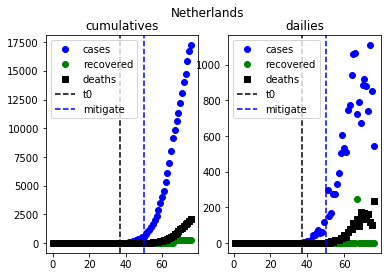

In [18]:
pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 64400000
pop['France'] = 66990000
pop['Netherlands'] = 17000000

mitigate = {}
mitigate['Italy'] = '3/9/20' #approximate date
mitigate['Netherlands'] = '3/12/20' #approximate date

t0 = np.where(DF["cum_cases"].values>5)[0][0] - 1# estimated day of first exposure? Need to make this a parameter

plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"],'bo', label="cases")
plt.plot(DF["cum_recover"],'go',label="recovered")
plt.plot(DF["cum_deaths"],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')

ind = np.where(mitigate[roi]==dates)[0][0]
plt.axvline(ind,color='b', linestyle="dashed", label='mitigate')

plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["daily_cases"],'bo', label="cases")
plt.plot(DF["daily_recover"],'go',label="recovered")
plt.plot(DF["daily_deaths"],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')

ind = np.where(mitigate[roi]==dates)[0][0]
plt.axvline(ind,color='b', linestyle="dashed", label='mitigate')

plt.suptitle(roi)
plt.legend()


print("t0 assumed to be: day "+str(t0))
print("t0 date: "+dates[t0])
print("mitigation date: "+dates[ind])
print(ind)


## Format JHU ROI data for Stan

In [ ]:
# int<lower = 1> n_obs;       // number of days observed
# int<lower = 1> n_theta;     // number of model parameters
# int<lower = 1> n_difeq;     // number of differential equations for yhat
# int<lower = 1> n_ostates;     // number of observed states
# int<lower = 1> n_pop;       // population
# real<lower = 1> n_scale;       // scale to match observed scale
# int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
# real t0;                // initial time point 
# real tm; //start day of mitigation
# real ts[n_obs];         // time points that were observed
# int<lower = 1> n_obs_predict;       // number of days to predict
# real ts_predict[n_obs_predict];         // 

stan_data = {}

stan_data['n_pop'] = pop[roi] 
stan_data['n_scale'] = 10000000 #use this instead of population

stan_date['n_theta'] = 11
stan_date['n_dfeq'] = 3
stan_date['n_ostates'] = 3

stan_data['t0'] = t0-1
stan_data['tm'] = ind
stan_data['ts'] = np.arange(t0,len(dates)) 
DF = DF.replace('NaN', 0)
DF = DF.replace(-1, 0)
stan_data['y'] = (DF[['daily_cases','daily_recover','daily_deaths']].to_numpy()).astype(int)[t0:,:]
stan_data['n_obs'] = len(dates) - t0

stan_data['ts_predict'] = np.arange(t0,len(dates)+365)
stan_data['n_obs_predict'] = len(dates) - t0 + 365

### Print data for Stan 

In [ ]:
print(model.stan_data)

# Load England School 1978 Influenza data 

In [ ]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [ ]:
# theta[1] ~ lognormal(log(0.1),1); //sigmac
# theta[2] ~ lognormal(log(0.1),1); //sigmar
# theta[3] ~ lognormal(log(0.1),1); //sigmad
# theta[4] ~ lognormal(log(0.1),1); //q
# theta[5] ~ lognormal(log(0.25),1); //beta 
# theta[6] ~ lognormal(log(0.25),1); //mbase = theta[5]; 
# theta[7] ~ lognormal(log(tm),5); //mlocation = theta[6]; 
# theta[8] ~ lognormal(log(1),5); //mrate = theta[7]; 
# theta[9] ~ lognormal(log(0.1),1);//cmax = theta[9];
# theta[10] ~ lognormal(log(0.1),1);//c50 = theta[10];
# theta[11] ~ lognormal(log(0.1),1);// theta_init = theta[11];
            
def init_fun():
        x = {'theta':
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(stan_data['tm']),1)]+
             [np.random.lognormal(np.log(1),5)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]
            }
        return x


## Fit Stan 

In [ ]:
n_chains=1
n_warmups=1000
n_iter=5000
n_thin=50

control = {'adapt_delta':0.95}
fit = stanrunmodel.sampling(data = model.stan_data,init = init_fun,control=control, chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)



In [ ]:
print(fit)

In [ ]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])

In [ ]:
ms=2 

x = range(len(DF["daily_cases"][t0:]))
     
plt.plot(x,DF["daily_cases"][t0:],'bo', label="cases",ms=ms)
plt.plot(x,DF["daily_recover"][t0:],'o',color='orange',label="unknown",ms=ms)
plt.plot(x,DF["daily_deaths"][t0:],'x',color='k',label="unknown",ms=ms)
  
lw=4
alpha = 0.5
labels = ['I','C']
c_ = ['r','b']
n = 2 
for i in range(n):
    plt.plot(model.stan_data['n_scale']*fit.extract()['u'][-1,:,i],label=labels[i],lw=lw,alpha=alpha,color=c_[i])

plt.legend()
plt.ylim((0,50000))
